## DNAnudge exercise

First I want to write down all the required functions to read the data from experiments folders and save them into 3D numpy array. Comments in the code.

Requires: `numpy`, `pandas`, `matplotlib`

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# read experiment folder path
# experiment_folder = sys.argv[1]

# define a function that will apply the data into the array
def fill_cycle(arr: np.ndarray, cycle: int, data: np.ndarray) -> np.ndarray:
    # go through each data entry
    for well in data:
        # split the list describing each well 
        x, y, val = well
        # save value to the position in the array
        arr[y, x, cycle] = val
        
    return arr

def read_experiment(experiment_folder):
    # create empty 3D numpy array
    #   first dimension represents row on a plate
    #   second dimension represents columns on a plate
    #   third dimension represents cycle
    arr = np.zeros((6, 12, 40))

    # read all cycles in the experiment
    for file in glob.glob(os.path.join(experiment_folder, '*.txt')):
        # parse out which cycle we're in
        filename = os.path.basename(file)
        cycle_n = int(filename.split('_')[1].split('.')[0])
        
        # read data from the text
        with open(file, 'r') as f:
            # it might be potentially dangerous to use eval but given that we're reading
            # from the machine output we might as well be a little cheeky 
            data = eval(f.read())

        # apply data to the array
        arr = fill_cycle(arr, cycle_n, data)
    
    return arr

def plot_experiment_array(arr):
    
    # first we need to transpose and reshape 3d array into 2d array with rows as 
    # timepoints (cycles) and columns as each reaction
    arr_reshaped = arr.transpose().reshape(40, 72)
    
    plt.plot(arr_reshaped)
    plt.show()

I can now save each experiment in a different array and plot the data

In [2]:
arr_1 = read_experiment('data/experiment1')
arr_2 = read_experiment('data/experiment2')

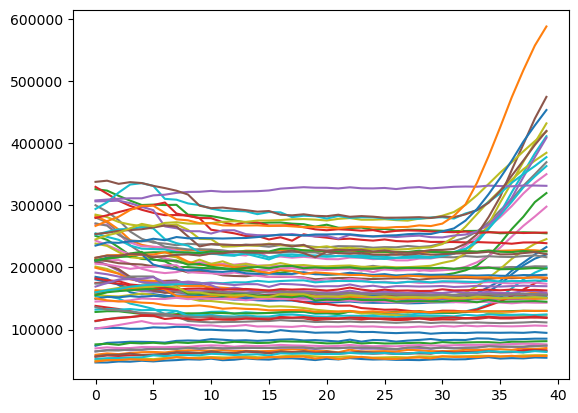

In [3]:
plot_experiment_array(arr_1)

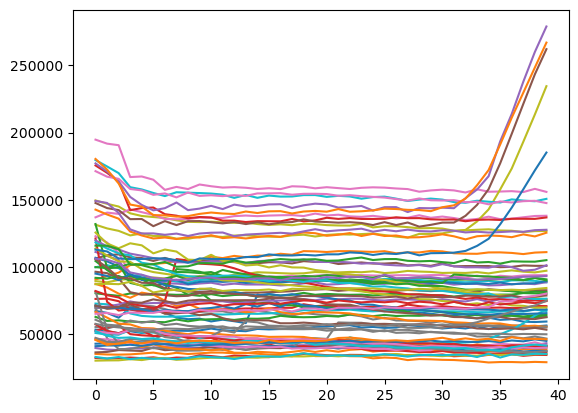

In [4]:
plot_experiment_array(arr_2)

The curves from both experiments indicate qPCR data output. However, only few samples go into the exponential phase and the baseline seems to be very variable. I want to see how the flourescence compares between the two experiments 

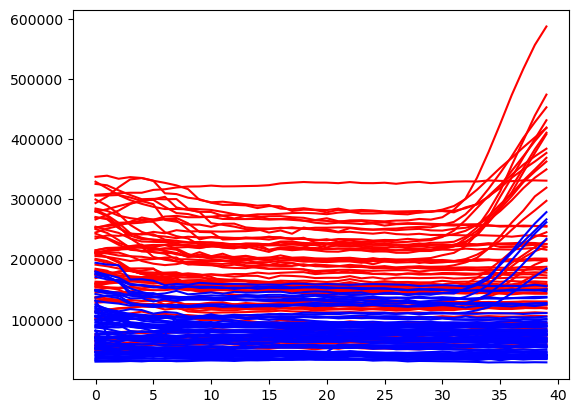

In [5]:
# transpose and reshape in 2-D 
a = arr_1.transpose().reshape(40, 72)
b = arr_2.transpose().reshape(40, 72)

plt.plot(a, color='r')
plt.plot(b, color='b')
plt.show()

It seems from the plot that flourescence in the experiment 1 is in average higher.

In [6]:
import pandas as pd

mean_1 = pd.DataFrame(arr_1.transpose().reshape(40, 72)).mean().mean()
mean_2 = pd.DataFrame(arr_2.transpose().reshape(40, 72)).mean().mean()

print(mean_1, mean_2)

173110.75416666668 80280.03576388888


That is correct, the average flourescence from the first experiment is higher.

Now I want to compare two wells between the two experiments and calculate some descriptive statistics for them.

In [7]:
# selected wells
wells = [arr_1[0,0,:], arr_2[0,0,:], arr_1[5, 6, :], arr_2[5, 6, :]]

# with descriptive statistics
pd.DataFrame(wells).T.describe()

,0,1,2,3
count,40.000000,40.000000,40.000000,40.000000
mean,82453.725000,54203.300000,133242.975000,34964.200000
std,2294.864165,1618.785113,6187.764028,4788.423306
min,73981.000000,50822.000000,127422.000000,29000.000000
25%,81581.000000,52779.500000,128848.500000,30937.500000
50%,82803.000000,54259.500000,130099.000000,33941.000000
75%,83840.250000,55562.500000,136973.750000,38772.250000
max,85860.000000,56793.000000,150140.000000,46115.000000


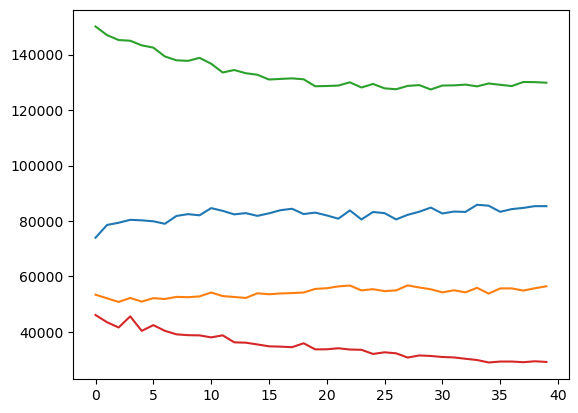

In [8]:
for w in wells:
    plt.plot(w)
plt.show()

After plotting them, I can see that none of them went into exponential phase.

Next, I'm interested in which samples do go up in the flourescence in the later cycles. 

In [9]:
# which wells had a peak in the last cycle (39)?
arr_1.argmax(axis=2)

array([[33,  0, 37,  4,  3,  9,  7, 17, 39, 37, 39, 37],
       [39,  0,  0,  1,  3,  5,  4,  6, 39, 39, 39, 39],
       [39, 39,  0, 39, 39,  0, 39, 39,  4,  4,  4, 39],
       [38, 39,  0,  0,  0,  0, 39, 39,  6,  6,  5, 34],
       [38, 39, 39, 39, 39,  0,  7,  0,  7,  6,  5, 34],
       [38,  0, 39, 39, 39,  0,  0,  0,  0, 18, 17, 36]])

Lets select those that had a peak after the 35st cycle in each and in both experiments


In [10]:
arr_1_up = arr_1[arr_1.argmax(axis=2) > 35]
arr_2_up = arr_2[arr_2.argmax(axis=2) > 35]

arr_1_both_up = arr_1[(arr_1.argmax(axis=2) > 35) & (arr_2.argmax(axis=2) > 35)]
arr_2_both_up = arr_2[(arr_1.argmax(axis=2) > 35) & (arr_2.argmax(axis=2) > 35)]

And if I plot these ...

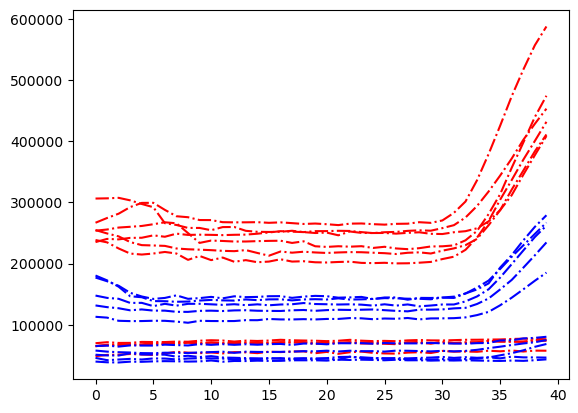

In [11]:
plt.plot(arr_1_both_up.transpose(), '-.', color='red')
plt.plot(arr_2_both_up.transpose(), '-.', color='blue')
plt.show()

I can still see that some of these don't take off into the exponential phase and become at the baselevel. Probably defining a baselevel would help clean the negative samples.

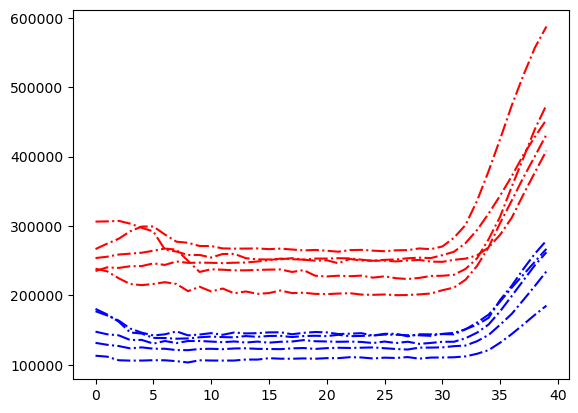

In [12]:
arr_1_select = (arr_1.argmax(axis=2) > 35) & (arr_1[:,:,39] > 100000)
arr_2_select = (arr_2.argmax(axis=2) > 35) & (arr_2[:,:,39] > 100000)

arr_1_both_select = arr_1[arr_1_select & arr_2_select]
arr_2_both_select = arr_2[arr_1_select & arr_2_select]

plt.plot(arr_1_both_select.transpose(), '-.', color='red')
plt.plot(arr_2_both_select.transpose(), '-.', color='blue')
plt.show()

These would be wells that were positive in both experiments (under the assumption that both experiments had the same samples). 